<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/1_load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does performance in pre-all star season predict playoff ranking? 
- supervised offline multi-class classification task
- performance measure: confusion matrix
- data source: https://www.nba.com/stats/teams/traditional/?sort=W&dir=-1&Season=2021-22&SeasonType=Regular%20Season 
- by predicting the probability of winning the championship based on mid-season (defined as regular season pre all-star game) performance of the NBA teams performance in the regular season before the All-Star game, 
  - As fans, we can tell whether our favorite team has a high chance to win this year during the middle of the season
  - As coaching staff and team manager, we can tell if we need to make a change in our roster to increase our chances

In [1]:
!pip install nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.1 MB/s 
  Created wheel for nba-api: filename=nba_api-1.1.11-py3-none-any.whl size=251504 sha256=650288ce04bbab95466f59a54231e83b57ea7f215cc7d2663a1b8dee661ba4ed
  Stored in directory: /root/.cache/pip/wheels/e3/f4/46/996128675381abc175e306642bae575d372dcf7efc4683e551
Successfully built nba-api


In [41]:
import pandas as pd
from nba_api.stats.endpoints import leaguedashteamstats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import os
from tqdm import tqdm
import numpy as np
from zlib import crc32
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]

# Gather data with [nba api](https://github.com/swar/nba_api)
- stats adjusted per 100 posessions, instead of per game, to account for the different pace each team plays at
- [glossary](https://www.nba.com/stats/help/glossary/) for column names  
- extra data: [advanced team stats](https://www.nba.com/stats/teams/advanced/?sort=W&dir=-1) 



In [14]:
per_mode = 'Per100Possessions'

def get_team_table(measure_type, season, season_type, season_segment=""):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashteamstats.md
  return leaguedashteamstats.LeagueDashTeamStats(
      per_mode_detailed=per_mode, 
      measure_type_detailed_defense=measure_type,
      season=season, 
      season_type_all_star=season_type,
      season_segment_nullable=season_segment).get_data_frames()[0]

In [17]:
def season_vs_playoff(start_year, end_year):
  output = None
  season_list = [str(i) + '-' + str(i+1)[2:] for i in range(start_year, end_year)]
  with tqdm(total=len(season_list)) as pbar:
    for season in season_list:
      season_df_base = get_team_table("Base", season, "Regular Season", "Pre All-Star")
      season_df_opponent = get_team_table("Opponent", season, "Regular Season", "Pre All-Star")
      season_df = season_df_base.merge(season_df_opponent, on = "TEAM_ID", how = "inner", suffixes = ("", "_y"))

      playoff_df_base = get_team_table("Base", season, "Playoffs")
      playoff_df_opponent = get_team_table("Opponent", season, "Playoffs")
      playoff_df = playoff_df_base.merge(playoff_df_opponent, on = "TEAM_ID", how = "inner", suffixes = ("", "_y"))
      
      # # win 4 games = win 1 round
      # # ranking = 0 for teams which didn't enter playoffs
      # # ranking = 5 for champion which won 4 rounds, 16 games
      # if playoff_df['W'].max() == 16:
      #   # to win a championship, you need to win 4 rounds of best-of-7 (4,4,4,4)
      #   playoff_df['PLAYOFF_RANKING'] = playoff_df['W'].apply(lambda x: int(x/4) + 1)
      # elif playoff_df['W'].max() == 15:
      #   # 2001-02 season is the last season with best-of-5 in 1st round (3,4,4,4) so lets add 1 back to make ranking easier
      #   playoff_df['PLAYOFF_RANKING'] = playoff_df['W'].apply(lambda x: int((x+1)/4) + 1)

      # winning championship = 1, else = 0
      playoff_df = playoff_df.loc[playoff_df['W'] == playoff_df['W'].max()]
      playoff_df[['PLAYOFF_RANKING']] = 1

      playoff_df = playoff_df[['TEAM_ID', 'PLAYOFF_RANKING']] 

      season_vs_playoff = pd.merge(season_df, playoff_df, on='TEAM_ID', how = 'outer')
      season_vs_playoff.fillna(0, inplace=True) # teams which are not in playoff will have 0 as PLAYOFF_RANKING
      season_vs_playoff['PLAYOFF_RANKING'] = season_vs_playoff['PLAYOFF_RANKING'].astype(int)
      season_vs_playoff['SEASON'] = season
      output = pd.concat([output,season_vs_playoff.sort_values(by='PLAYOFF_RANKING', ascending = False).reset_index(drop=True)], axis = 0)

      pbar.update(1)
  
  return output

In [18]:
df = season_vs_playoff(start_year = 1996, end_year = 2022)
df

100%|██████████| 26/26 [01:05<00:00,  2.52s/it]


,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLUS_MINUS_y,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,OPP_FGM_RANK,OPP_FGA_RANK,OPP_FG_PCT_RANK,OPP_FG3M_RANK,OPP_FG3A_RANK,OPP_FG3_PCT_RANK,OPP_FTM_RANK,OPP_FTA_RANK,OPP_FT_PCT_RANK,OPP_OREB_RANK,OPP_DREB_RANK,OPP_REB_RANK,OPP_AST_RANK,OPP_TOV_RANK,OPP_STL_RANK,OPP_BLK_RANK,OPP_BLKA_RANK,OPP_PF_RANK,OPP_PFD_RANK,OPP_PTS_RANK,PLUS_MINUS_RANK_y,CFID_y,CFPARAMS_y,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,3,1,1,1,13,1,1,2,12,10,12,26,27,11,2,8,2,2,1,7,27,1,1,21,1,1,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,52.4,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,-12.8,3,1,1,1,13,10,24,6,7,18,1,3,3,14,22,6,8,2,11,4,1,27,6,29,3,1,10,Chicago Bulls,1,1996-97
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,18,9,7,8,3,16,6,23,1,1,13,14,19,4,11,1,3,29,7,19,9,6,3,27,9,5,10,Atlanta Hawks,Atlanta Hawks,46,31,15,0.674,54.8,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,-5.8,18,9,7,8,3,13,29,3,21,25,6,1,1,8,25,20,26,10,21,5,6,9,14,27,5,5,10,Atlanta Hawks,0,1996-97
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,3,14,15,15,18,20,18,19,26,25,21,4,7,7,17,24,23,14,8,20,2,22,17,9,17,17,10,Minnesota Timberwolves,Minnesota Timberwolves,48,23,25,0.479,52.1,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,2.2,3,14,15,15,18,14,13,14,8,9,22,21,21,19,18,17,21,14,13,7,22,2,17,13,17,17,10,Minnesota Timberwolves,0,1996-97
3,1610612763,Vancouver Grizzlies,51,9,42,0.176,53.1,38.1,88.6,0.430,5.8,17.3,0.337,15.6,22.4,0.696,14.1,28.4,42.5,25.1,17.2,9.6,6.1,6.4,23.4,0.0,97.5,-12.1,1,29,29,29,10,18,3,27,19,19,23,29,29,27,10,28,27,7,14,6,8,27,8,29,29,29,10,Vancouver Grizzlies,Vancouver Grizzlies,51,9,42,0.176,53.1,41.7,88.4,0.472,6.6,18.1,0.363,19.7,26.7,0.736,16.7,33.8,50.5,26.7,17.9,9.6,6.4,6.1,21.2,23.4,109.6,12.1,1,29,29,29,10,29,25,27,15,14,18,12,12,16,29,29,29,28,8,24,27,8,1,22,28,29,10,Vancouver Grizzlies,0,1996-97
4,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,13,6,5,6,11,3,28,1,28,28,10,2,5,6,29,7,18,1,11,4,16,11,26,4,4,4,10,Utah Jazz,Utah Jazz,47,33,14,0.702,53.0,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,-7.1,13,6,5,6,11,3,3,5,19,26,2,28,27,23,6,3,3,5,9,8,11,16,29,4,10,4,10,Utah Jazz,0,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6,46.3,26.0,15.3,7.4,4.4,4.6,17.5,19.9,110.0,

In [19]:
# save to google drive
os.chdir('/content/drive/MyDrive/Colab Notebooks')
df.to_csv('nba_pre_all_star_vs_playoff.csv', index = False)
# download local copy
from google.colab import files
files.download("nba_pre_all_star_vs_playoff.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
df = pd.read_csv('https://github.com/WillKWL/PublicData/raw/main/raw/nba_pre_all_star_vs_playoff.csv')
df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLUS_MINUS_y,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,OPP_FGM_RANK,OPP_FGA_RANK,OPP_FG_PCT_RANK,OPP_FG3M_RANK,OPP_FG3A_RANK,OPP_FG3_PCT_RANK,OPP_FTM_RANK,OPP_FTA_RANK,OPP_FT_PCT_RANK,OPP_OREB_RANK,OPP_DREB_RANK,OPP_REB_RANK,OPP_AST_RANK,OPP_TOV_RANK,OPP_STL_RANK,OPP_BLK_RANK,OPP_BLKA_RANK,OPP_PF_RANK,OPP_PFD_RANK,OPP_PTS_RANK,PLUS_MINUS_RANK_y,CFID_y,CFPARAMS_y,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,3,1,1,1,13,1,1,2,12,10,12,26,27,11,2,8,2,2,1,7,27,1,1,21,1,1,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,52.4,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,-12.8,3,1,1,1,13,10,24,6,7,18,1,3,3,14,22,6,8,2,11,4,1,27,6,29,3,1,10,Chicago Bulls,1,1996-97
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,18,9,7,8,3,16,6,23,1,1,13,14,19,4,11,1,3,29,7,19,9,6,3,27,9,5,10,Atlanta Hawks,Atlanta Hawks,46,31,15,0.674,54.8,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,-5.8,18,9,7,8,3,13,29,3,21,25,6,1,1,8,25,20,26,10,21,5,6,9,14,27,5,5,10,Atlanta Hawks,0,1996-97
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,3,14,15,15,18,20,18,19,26,25,21,4,7,7,17,24,23,14,8,20,2,22,17,9,17,17,10,Minnesota Timberwolves,Minnesota Timberwolves,48,23,25,0.479,52.1,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,2.2,3,14,15,15,18,14,13,14,8,9,22,21,21,19,18,17,21,14,13,7,22,2,17,13,17,17,10,Minnesota Timberwolves,0,1996-97
3,1610612763,Vancouver Grizzlies,51,9,42,0.176,53.1,38.1,88.6,0.430,5.8,17.3,0.337,15.6,22.4,0.696,14.1,28.4,42.5,25.1,17.2,9.6,6.1,6.4,23.4,0.0,97.5,-12.1,1,29,29,29,10,18,3,27,19,19,23,29,29,27,10,28,27,7,14,6,8,27,8,29,29,29,10,Vancouver Grizzlies,Vancouver Grizzlies,51,9,42,0.176,53.1,41.7,88.4,0.472,6.6,18.1,0.363,19.7,26.7,0.736,16.7,33.8,50.5,26.7,17.9,9.6,6.4,6.1,21.2,23.4,109.6,12.1,1,29,29,29,10,29,25,27,15,14,18,12,12,16,29,29,29,28,8,24,27,8,1,22,28,29,10,Vancouver Grizzlies,0,1996-97
4,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,13,6,5,6,11,3,28,1,28,28,10,2,5,6,29,7,18,1,11,4,16,11,26,4,4,4,10,Utah Jazz,Utah Jazz,47,33,14,0.702,53.0,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,-7.1,13,6,5,6,11,3,3,5,19,26,2,28,27,23,6,3,3,5,9,8,11,16,29,4,10,4,10,Utah Jazz,0,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6,46.3,26.0,15.3,7.4,4.4,4.6,17.5,19.9,110.0

In [47]:
pd.DataFrame(df.dtypes).T

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLUS_MINUS_y,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,OPP_FGM_RANK,OPP_FGA_RANK,OPP_FG_PCT_RANK,OPP_FG3M_RANK,OPP_FG3A_RANK,OPP_FG3_PCT_RANK,OPP_FTM_RANK,OPP_FTA_RANK,OPP_FT_PCT_RANK,OPP_OREB_RANK,OPP_DREB_RANK,OPP_REB_RANK,OPP_AST_RANK,OPP_TOV_RANK,OPP_STL_RANK,OPP_BLK_RANK,OPP_BLKA_RANK,OPP_PF_RANK,OPP_PFD_RANK,OPP_PTS_RANK,PLUS_MINUS_RANK_y,CFID_y,CFPARAMS_y,PLAYOFF_RANKING,SEASON
0,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object


# Remove duplicate columns and outlier rows

In [48]:
# remove duplicate columns and ranking columns since we will clean the features later on
df = df.loc[:, [not((('RANK' in x) | ('_y' in x)) & ('RANKING' not in x)) for x in df.columns]]
df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,1,1996-97
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,0,1996-97
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,10,Minnesota Timberwolves,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,0,1996-97
3,1610612763,Vancouver Grizzlies,51,9,42,0.176,53.1,38.1,88.6,0.430,5.8,17.3,0.337,15.6,22.4,0.696,14.1,28.4,42.5,25.1,17.2,9.6,6.1,6.4,23.4,0.0,97.5,-12.1,10,Vancouver Grizzlies,41.7,88.4,0.472,6.6,18.1,0.363,19.7,26.7,0.736,16.7,33.8,50.5,26.7,17.9,9.6,6.4,6.1,21.2,23.4,109.6,0,1996-97
4,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,0,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6,46.3,26.0,15.3,7.4,4.4,4.6,17.5,19.9,110.0,4.3,10,Cleveland Cavaliers,39.8,90.2,0.442,11.7,34.5,0.340,14.3,18.8,0.758,11.2,33.5,44.7,23.8,14.3,8.9,4.6,4.4,19.9,17.5,105.7,0,2021-22
768,1610612741,Chicago Bulls,59,38,21,0.644,48.4,42.4,87.7,0.483,11.3,30.0,0.376,17.4,21.3,0.817,9.0,34.7,43.7,24.6,13.1,7.1,4.5,5.1,18.7,17.7,113.4,2.3,10,Chicago Bulls,41.3,88.5,0.467,11.8,32.4,0.363,16.7,21.0,0.797,9.4,34.1,43.5,25.2,13.3,7.4,5.1,4.5,17.7,18.7,111.1,0,2021-22
769,1610612766,Charlotte Hornets,60,29,31,0.483,47.5,41.2,90.2,0.456,13.4,37.6,0.356,15.5,21.0,0.737,10.8,33.3,44.1,26.6,13.0,8.5,4.7,4.8,19.5,19.3,111.3,-0.9,10,Charlotte Hornets,40.9,88.4,0.463,13.7,38.4,0.356,16.7,21.9,0.762,10.9,35.9,46.9,25.6,15.0,7.4,4.8,4.7,19.3,19.5,112.1,0,2021-22
770,1610612751,Brooklyn Nets,59,31,28,0.525,48.4,41.6,89.1,0.467,11.2,32.1,0.351,16.9,21.0,0.806,10.3,34.7,45.1,24.9,13.9,7.1,5.3,5.2,20.0,19.4,111.4,0.0,10,Brooklyn Nets,40.9,91.0,0.449,12.1,36.4,0.333,17.5,21.7,0.803,11.2,33.8,45.0,23.8,13.2,7.8,5.2,5.3,19.4,20.0,111.4,0,2021-22


In [49]:
df.describe()

,TEAM_ID,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING
count,7.720000e+02,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.0,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000
mean,1.610613e+09,50.606218,25.303109,25.303109,0.499927,50.931347,39.070725,86.721762,0.450617,7.552591,21.299741,0.352225,19.233679,25.505699,0.755329,11.930829,32.950259,44.883031,23.044301,15.545078,8.098187,5.247409,5.247668,22.495337,14.376554,104.927850,0.006606,10.0,39.058290,86.699611,0.450501,7.557642,21.312435,0.353225,19.249223,25.529404,0.754902,11.922927,32.947539,44.871114,23.037306,15.546244,8.094819,5.247668,5.247280,22.484456,22.495207,104.920855,0.033679
std,8.614750e+00,12.211405,10.248601,10.268956,0.161748,1.968573,1.697598,2.311684,0.017928,2.829515,7.546998,0.024174,2.451597,3.376242,0.034613,1.891570,1.870999,1.998381,2.046821,1.527708,1.065883,0.998342,0.853045,2.424332,10.171170,4.639576,4.990483,0.0,1.833638,2.361206,0.017510,2.535047,6.832140,0.022353,2.395091,3.318580,0.021278,1.601007,1.797096,1.819988,1.792681,1.578010,0.880396,0.853045,0.998406,2.349825,2.424216,4.469277,0.180518
min,1.610613e+09,4.000000,0.000000,0.000000,0.000000,45.500000,33.500000,78.500000,0.373000,1.500000,5.100000,0.263000,10.600000,16.900000,0.560000,7.500000,26.200000,37.600000,15.400000,11.100000,5.700000,1.900000,3.100000,16.900000,0.000000,89.500000,-15.500000,10.0,30.300000,76.000000,0.368000,1.800000,10.000000,0.159000,14.000000,18.400000,0.595000,8.100000,27.000000,39.700000,16.900000,11.600000,5.500000,3.100000,1.900000,17.400000,16.900000,86.000000,0.000000
25%,1.610613e+09,49.000000,19.000000,18.000000,0.388750,49.600000,38.000000,85.200000,0.439000,5.300000,15.600000,0.338000,17.400000,22.900000,0.737000,10.600000,31.775000,43.500000,21.700000,14.475000,7.400000,4.600000,4.700000,20.800000,0.200000,101.900000,-3.300000,10.0,38.000000,85.300000,0.439000,5.700000,16.300000,0.342000,17.500000,23.100000,0.743000,10.800000,31.875000,43.700000,21.900000,14.500000,7.500000,4.700000,4.600000,20.700000,20.800000,102.200000,0.000000
50%,1.610613e+09,52.000000,25.000000,25.000000,0.509000,51.200000,39.050000,86.850000,0.450000,7.000000,19.900000,0.353000,19.100000,25.500000,0.758000,11.800000,32.900000,44.900000,22.900000,15.500000,8.000000,5.200000,5.200000,22.400000,20.200000,104.700000,0.000000,10.0,39.200000,86.800000,0.452000,6.900000,19.300000,0.355000,19.100000,25.350000,0.755000,11.900000,33.000000,44.800000,23.000000,15.500000,8.000000,5.200000,5.200000,22.500000,22.400000,105.050000,0.000000
75%,1.610613e+09,55.000000,32.000000,32.000000,0.615000,52.400000,40.300000,88.225000,0.462000,9.500000,26.325000,0.368000,20.800000,27.700000,0.778000,13.200000,34.200000,46.200000,24.400000,16.500000,8.800000,5.900000,5.700000,24.000000,22.000000,108.325000,3.500000,10.0,40.300000,88.300000,0.462000,9.125000,25.225000,0.366250,20.800000,27.700000,0.769000,13.000000,34.025000,46.000000,24.200000,16.600000,8.600000,5.700000,5.900000,24.100000,24.000000,108.000000,0.000000
max,1.610613e+09,82.000000,62.000000,71.000000,1.000000,56.600000,43.700000,93.800000,0.510000,17.100000,45.300000,0.435000,30.200000,39.100000,0.844000,19.100000,40.100000,52.600000,30.500000,21.600000,14.200000,10.400000,9.200000,31.000000,28.500000,118.200000,13.900000,10.0,44.100000,93.300000,0.49300

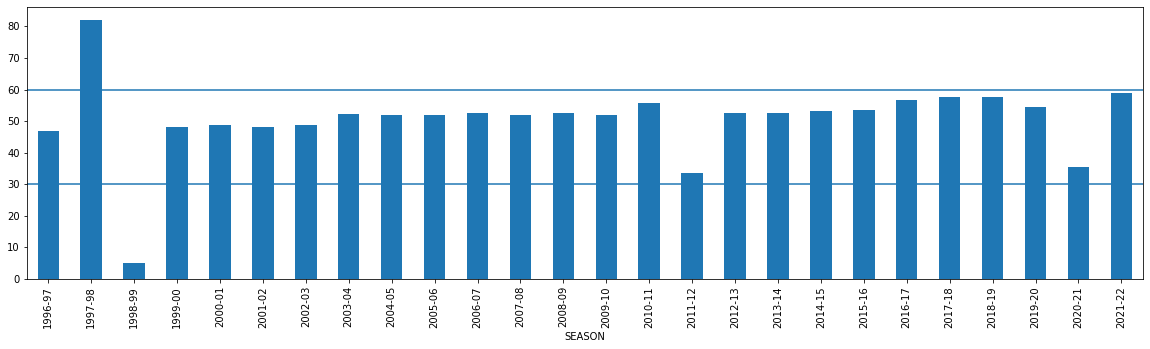

In [50]:
# consider removing outlier in terms of games played 
# since those records are not representative samples of mid-season performance
# 1997-98: 82 games played = whole season but not mid-season, 
  # all-star game was held in Feb (Kobe's debut for youngest all-star player)
  # season lasted from Oct to Apr
# 1998-89: see 1998 NBA lockout
  # < 10 games played = too small of a sample size to gauge mid-season performance
# 2011-12: see 2011 NBA lockout
# 2020-21: see postponed season due to COVID-19
df.groupby('SEASON').GP.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [51]:
# cannot pass this in sklearn pipeline so let's do it on dataset level
# drop any season with games played <= 30 or >= 60 such that we have a large enough sample to gauge mid-season performance
df = df.loc[(df.GP >= 30) & (df.GP <= 60)]

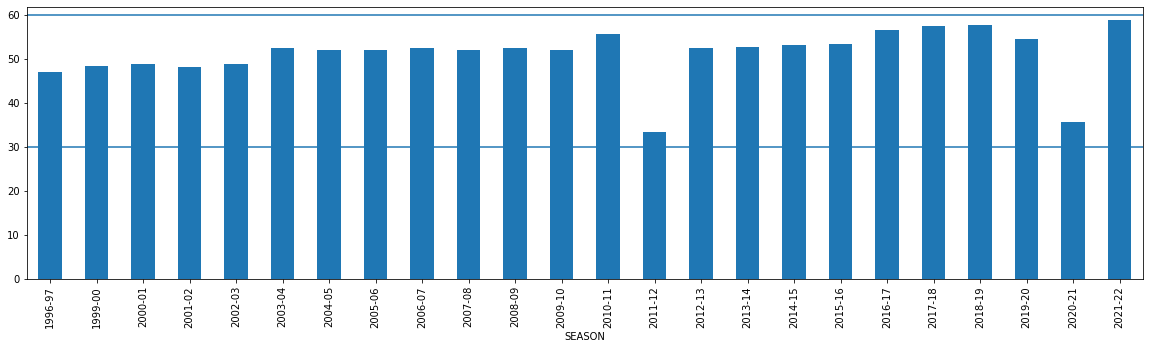

In [52]:
# now fixed
df.groupby('SEASON').GP.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [53]:
# fix datatypes
df['TEAM_ID'] = df['TEAM_ID'].astype(str)
df['CFID'] = df['CFID'].astype(str)
df['PLAYOFF_RANKING'] = df['PLAYOFF_RANKING'].astype('category')
df['SEASON'] = df['SEASON'].astype('category')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# Train test split with unique identifier = TEAM_ID + SEASON
- hashing unique identifier
- alternative: stratified sampling by season

## *use stratified sampling instead

In [54]:
# unique id = team id + season
df['UNIQUE_ID'] = df['TEAM_ID'].astype(str) + df['SEASON'].str.replace('-','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
# instead of train-test_split by random shuffling, hash the unique identifier for train-test split
# slight modification to the technique from Hands On Machine Learning by Aurélien Géron
def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  threshold = np.quantile(ids.apply(lambda x: crc32(np.int64(x))), test_ratio) # instead of using test_ratio * 2**32 as the threshold, this is more accurate
  in_test_set = ids.apply(lambda x: crc32(np.int64(x)) < threshold) 
  return data.loc[~in_test_set], data.loc[in_test_set]

In [56]:
train_set, test_set = split_data_with_id_hash(df, 0.2, "UNIQUE_ID")

In [57]:
print(f"size of full dataset: {df.shape}")
print(f"train-test ratio: {train_set.shape[0] / df.shape[0]:0.2} / {test_set.shape[0] / df.shape[0]:0.2}")

size of full dataset: (712, 53)
train-test ratio: 0.8 / 0.2


In [58]:
# save to google drive
os.chdir('/content/drive/MyDrive/Colab Notebooks')
train_set.to_pickle('nba_pre_all_star_vs_playoff_train.pkl')
test_set.to_pickle('nba_pre_all_star_vs_playoff_test.pkl')
# download local copy
from google.colab import files
files.download("nba_pre_all_star_vs_playoff_train.pkl")
files.download("nba_pre_all_star_vs_playoff_test.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>